# V1 complex cells RF
# a) 2D window [x,y]
# b) Raised cosine [ori] (almost)

In [4]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
t_train = np.load('t_train.npy')
t_test = np.load('t_test.npy')

n = 28
pat = x_train[15267,:].reshape(n,n)/255

angles = np.array([0, 1/6, 1/4, 1/3, 1/2, 2/3, 3/4, 5/6])*np.pi

def visualize_Hypercolumn_8ori(mfr, n, FR):

    titles = ['0°','30°','45°','60°','90°','120°','135°','150°']
    nL = n**2
    
    for ii in range(8):
        
        a = asarray(mfr[nL*ii : nL*(ii+1)]/FR)
        b = a.reshape(n,n)
        
        plt.subplot(2,4,ii+1)
        plt.imshow(b,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[ii])

[X,Y] = np.meshgrid(range(n), range(n))

taum = 10*ms
taui = 50*ms
taue = 100*ms

dge = 80*mV
dge_c = 200*mV

duration = 500*ms

eqsPOISSON='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsLGN='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

################################################### Retina ################################################################

nL1 = n**2

L1 = NeuronGroup(nL1,
                 eqsPOISSON,
                 threshold='rand()<rates*dt')

L1.x = X.flatten()
L1.y = Y.flatten()
FR = 200*Hz
L1.rates = pat.flatten()*FR

################################################### LGN 2A ################################################################

nL2a = n**2

L2a = NeuronGroup(nL2a,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2a.x = X.flatten()
L2a.y = Y.flatten()

e1a = Synapses(L1, L2a, on_pre='ge += dge')
e1a.connect(condition = 'i==j')

i1a = Synapses(L1, L2a, on_pre='gi -= 1/8*dge')
i1a.connect(condition = 'sqrt((x_pre-x_post)**2+(y_pre-y_post)**2)<2 and i!=j')

################################################ V1 simple A ##############################################################

nL3a = nL2a*8

L3a = NeuronGroup(nL3a,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3a.ori = np.repeat(angles, nL2a)

X3 = np.tile(X.flatten(), (1,8))
X3.flatten()
L3a.x = X3.flatten()

Y3 = np.tile(Y.flatten(), (1,8))
Y3.flatten()
L3a.y = Y3.flatten()

angles = np.array([0, 1/6, 1/4, 1/3, 1/2, 2/3, 3/4, 5/6])*np.pi

ce = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ce += 'ori_post==0 and x_post==x_pre or '
ce += 'ori_post==1/6*pi and abs(1.5*(x_post-x_pre)-(y_post-y_pre))<1 or '
ce += 'ori_post==1/4*pi and abs(y_post-y_pre-x_post+x_pre)==0 or '
ce += 'ori_post==1/3*pi and abs((x_post-x_pre)-1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==1/2*pi and y_post==y_pre or '
ce += 'ori_post==2/3*pi and abs((x_post-x_pre)+1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==3/4*pi and abs(y_post-y_pre+x_post-x_pre)==0 or '
ce += 'ori_post==5/6*pi and abs(1.5*(x_post-x_pre)+(y_post-y_pre))<1)'

ci = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ci += 'ori_post==0 and abs(x_post-x_pre)==1 or '
ci += 'ori_post==1/6*pi and (abs(1.5*(x_post-x_pre-1)-(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)-(y_post-y_pre))<1) or '
ci += 'ori_post==1/4*pi and abs(y_post-y_pre-x_post+x_pre)==1 or '
ci += 'ori_post==1/3*pi and (abs((x_post-x_pre)-1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)-1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==1/2*pi and abs(y_post-y_pre)==1 or '
ci += 'ori_post==2/3*pi and (abs((x_post-x_pre)+1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)+1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==3/4*pi and abs(y_post-y_pre+x_post-x_pre)==1 or '
ci += 'ori_post==5/6*pi and (abs(1.5*(x_post-x_pre-1)+(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)+(y_post-y_pre))<1))'

e2a = Synapses(L2a, L3a, on_pre='ge += 1/5*dge')
e2a.connect(condition = ce)

i2a = Synapses(L2a, L3a, on_pre='gi -= 1/9*dge')
i2a.connect(condition = ci)

############################################## V1 A complex A #############################################################

naa = 10
nL4aa = naa**2*8
[X4aa,Y4aa] = np.meshgrid(range(naa), range(naa))

L4aa = NeuronGroup(nL4aa,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4aa.ori = np.repeat(angles, naa**2)

X4 = np.tile(X4aa.flatten(), (1,8))
X4.flatten()
L4aa.x = X4.flatten()

Y4 = np.tile(Y4aa.flatten(), (1,8))
Y4.flatten()
L4aa.y = Y4.flatten()

e3aa = Synapses(L3a, L4aa, on_pre='ge += 1/9*dge_c')
e3aa.connect(condition = 'ori_post==ori_pre and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

e3aa2 = Synapses(L3a, L4aa, on_pre='ge += 1/18*dge_c')
e3aa2.connect(condition = 'cos(2*(ori_post-ori_pre))>0.49 and ori_post!=ori_pre and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

e3aa3 = Synapses(L3a, L4aa, on_pre='ge -= 1/18*dge_c')
e3aa3.connect(condition = 'cos(2*(ori_post-ori_pre))<-0.49 and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

e3aa4 = Synapses(L3a, L4aa, on_pre='ge -= 1/9*dge_c')
e3aa4.connect(condition = 'cos(2*(ori_post-ori_pre))==-1 and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

sp1 = SpikeMonitor(L1)
sp2a = SpikeMonitor(L2a)
sp3a = SpikeMonitor(L3a)
sp4aa = SpikeMonitor(L4aa)

run(duration)

MFR1 = sp1.count/duration
MFR2a = sp2a.count/duration
MFR3a = sp3a.count/duration
MFR4aa = sp4aa.count/duration

# $\color{red}{\text{SIMPLE CELLS}}$

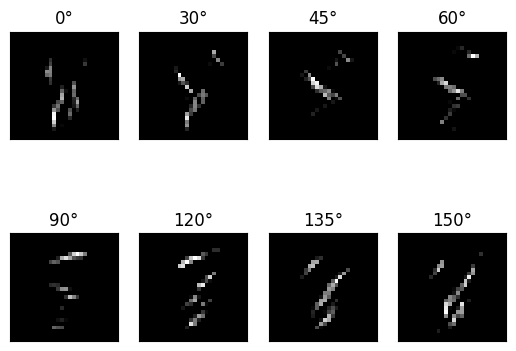

In [5]:
visualize_Hypercolumn_8ori(MFR3a, n, FR)

# $\color{red}{\text{COMPLEX CELLS}}$

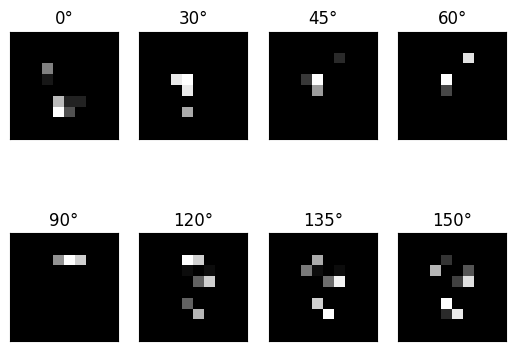

In [6]:
visualize_Hypercolumn_8ori(MFR4aa, naa, FR)